# Detect anomalies in a timeseries using an Autoencoder.

## anomaly detection using keras



## Introduction
This script demonstrates how you can use a reconstruction convolutional
autoencoder model to detect anomalies in timeseries data.

## Setup


In [24]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt


## Load the data
We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artifical
timeseries data containing labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.
We will use the `art_daily_small_noise.csv` file for training and the
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.

In [39]:
# Add NEW DR
# Where did the data come from?
# Df head
# https://github.com/numenta/NAB/tree/master/data
# https://www.kaggle.com/code/mohamedahmedae/anomalydetection-mlmodels-lstmmodel
# https://www.kaggle.com/code/mineshjethva/timeseries-anomaly-detection-using-rnn-autoencoder/notebook

master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)


In [46]:
df_small_noise

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


In [47]:
df_daily_jumpsup

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


In [41]:
df_small_noise.compare(df_daily_jumpsup)

value           
                          self      other
timestamp                                
2014-04-01 00:00:00  18.324919  19.761252
2014-04-01 00:05:00  21.970327  20.500833
2014-04-01 00:10:00  18.624806  19.961641
2014-04-01 00:15:00  21.953684  21.490266
2014-04-01 00:20:00  21.909120  20.187739
...                        ...        ...
2014-04-14 23:35:00  20.211195  18.074649
2014-04-14 23:40:00  20.531041  21.002014
2014-04-14 23:45:00  19.032127  20.566713
2014-04-14 23:50:00  21.798801  18.254193
2014-04-14 23:55:00  18.682620  21.863147

[4032 rows x 2 columns]

In [52]:
df_small_noise.index

DatetimeIndex(['2014-04-01 00:00:00', '2014-04-01 00:05:00',
               '2014-04-01 00:10:00', '2014-04-01 00:15:00',
               '2014-04-01 00:20:00', '2014-04-01 00:25:00',
               '2014-04-01 00:30:00', '2014-04-01 00:35:00',
               '2014-04-01 00:40:00', '2014-04-01 00:45:00',
               ...
               '2014-04-14 23:10:00', '2014-04-14 23:15:00',
               '2014-04-14 23:20:00', '2014-04-14 23:25:00',
               '2014-04-14 23:30:00', '2014-04-14 23:35:00',
               '2014-04-14 23:40:00', '2014-04-14 23:45:00',
               '2014-04-14 23:50:00', '2014-04-14 23:55:00'],
              dtype='datetime64[ns]', name='timestamp', length=4032, freq=None)

In [42]:
# https://www.educative.io/answers/how-to-compare-two-dataframes-in-pandas
df_small_noise.compare(df_daily_jumpsup, keep_equal=True)

value           
                          self      other
timestamp                                
2014-04-01 00:00:00  18.324919  19.761252
2014-04-01 00:05:00  21.970327  20.500833
2014-04-01 00:10:00  18.624806  19.961641
2014-04-01 00:15:00  21.953684  21.490266
2014-04-01 00:20:00  21.909120  20.187739
...                        ...        ...
2014-04-14 23:35:00  20.211195  18.074649
2014-04-14 23:40:00  20.531041  21.002014
2014-04-14 23:45:00  19.032127  20.566713
2014-04-14 23:50:00  21.798801  18.254193
2014-04-14 23:55:00  18.682620  21.863147

[4032 rows x 2 columns]

In [55]:
# https://www.skytowner.com/explore/checking_differences_between_two_indexes_in_pandas
a = df_small_noise.index
b = df_daily_jumpsup.index
a.difference(b)

DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)

In [58]:
# https://www.statology.org/pandas-merge-on-index/
df3  = pd.merge(df_small_noise, df_daily_jumpsup, left_index=True, right_index=True)
df3

,value_x,value_y
timestamp,,
2014-04-01 00:00:00,18.324919,19.761252
2014-04-01 00:05:00,21.970327,20.500833
2014-04-01 00:10:00,18.624806,19.961641
2014-04-01 00:15:00,21.953684,21.490266
2014-04-01 00:20:00,21.909120,20.187739
...,...,...
2014-04-14 23:35:00,20.211195,18.074649
2014-04-14 23:40:00,20.531041,21.002014
2014-04-14 23:45:00,19.032127,20.566713


In [59]:
# https://www.geeksforgeeks.org/how-to-compare-two-columns-in-pandas/
df3['new'] = np.where((df3['value_x'] <= df3['value_y']), df3['value_x'], np.nan)
df3

,value_x,value_y,new
timestamp,,,
2014-04-01 00:00:00,18.324919,19.761252,18.324919
2014-04-01 00:05:00,21.970327,20.500833,NaN
2014-04-01 00:10:00,18.624806,19.961641,18.624806
2014-04-01 00:15:00,21.953684,21.490266,NaN
2014-04-01 00:20:00,21.909120,20.187739,NaN
...,...,...,...
2014-04-14 23:35:00,20.211195,18.074649,NaN
2014-04-14 23:40:00,20.531041,21.002014,20.531041
2014-04-14 23:45:00,19.032127,20.566713,19.032127


## Quick look at the data

In [26]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())


                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


## Visualize the data
### Timeseries data without anomalies
We will use the following data for training.

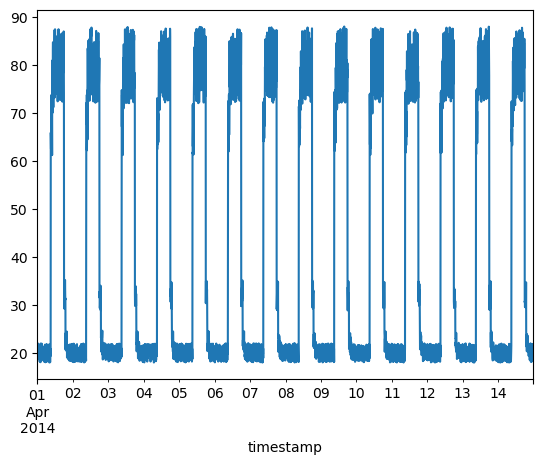

In [27]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()


### Timeseries data with anomalies
We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

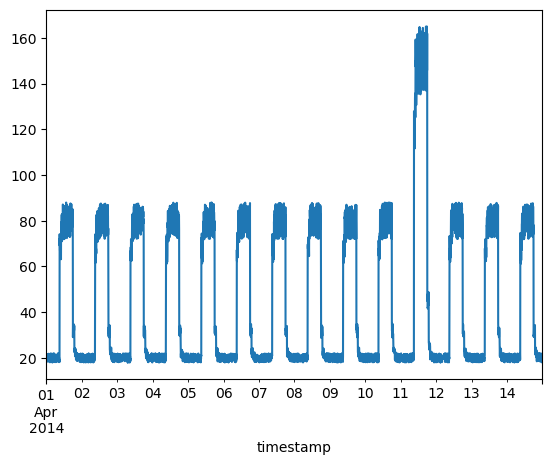

In [28]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()


## Prepare training data
Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.
-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [29]:
# Add NEW DR
# sanity check
df_train_vals = (df_small_noise - df_small_noise.mean()) / df_small_noise.std()


In [30]:
# Add NEW DR
# https://www.w3resource.com/pandas/dataframe/dataframe-head.php 
# The head() function is used to get the first n rows.
# This function returns the first n rows for the object based on position. 
# It is useful for quickly testing if your object has the right type of data in it.

df_train_vals.head()


,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [31]:
df_train_vals.shape

(4032, 1)

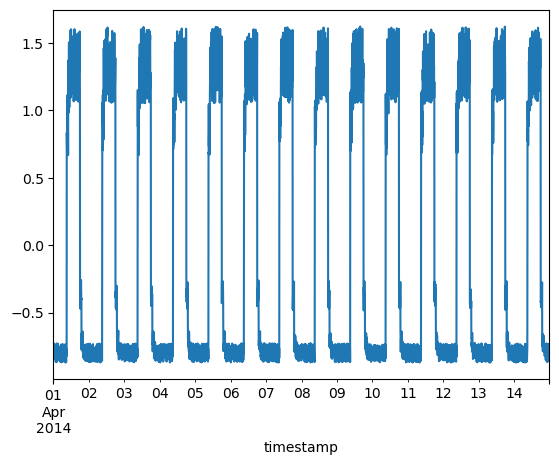

In [32]:
# Add NEW DR
# Replot output of sanity check
fig, ax = plt.subplots()
df_train_vals.plot(legend=False, ax=ax)
plt.show()

In [6]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))


Number of training samples: 4032


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [ ]:
# Add NEW DR
TIME_STEPS = 288

In [7]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


Training input shape:  (3745, 288, 1)


In [33]:

x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [36]:
x_train.shape

(3745, 288, 1)

## Build a model
We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [8]:
# https://www.tensorflow.org/tutorials/images/cnn
# 

model = keras.Sequential(
    [
        # Add NEW DR
        # Add comments in for each layer https://keras.io/api/layers/core_layers/input/
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        # https://keras.io/api/layers/convolution_layers/convolution1d/
        # https://shivapriya-katta.medium.com/time-series-forecasting-using-conv1d-lstm-multiple-timesteps-into-future-acc684dcaaa
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # https://keras.io/api/layers/regularization_layers/dropout/
        # https://www.oreilly.com/library/view/machine-learning-for/9781786469878/252b7560-e262-49c4-9c8f-5b78d2eec420.xhtml
        layers.Dropout(rate=0.2),
        # https://keras.io/api/layers/convolution_layers/convolution1d/
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # https://keras.io/api/layers/convolution_layers/convolution1d_transpose/ 
        # https://www.geeksforgeeks.org/python-tensorflow-tf-keras-layers-conv1dtranspose-function/
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # https://keras.io/api/layers/regularization_layers/dropout/
        layers.Dropout(rate=0.2),
        # https://keras.io/api/layers/convolution_layers/convolution1d_transpose/
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        # https://keras.io/api/layers/convolution_layers/convolution1d_transpose/
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## Train the model
Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [37]:
# Add NEW DR

history = model.fit(
    x_train,
    x_train,
    epochs=200,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/200
27/27 [==============================] - 2s 88ms/step - loss: 0.0195 - val_loss: 0.0279
Epoch 2/200
27/27 [==============================] - 2s 69ms/step - loss: 0.0188 - val_loss: 0.0281
Epoch 3/200
27/27 [==============================] - 2s 88ms/step - loss: 0.0180 - val_loss: 0.0289
Epoch 4/200
27/27 [==============================] - 2s 78ms/step - loss: 0.0174 - val_loss: 0.0284
Epoch 5/200
27/27 [==============================] - 3s 110ms/step - loss: 0.0168 - val_loss: 0.0265
Epoch 6/200
27/27 [==============================] - 2s 84ms/step - loss: 0.0161 - val_loss: 0.0290
Epoch 7/200
27/27 [==============================] - 2s 76ms/step - loss: 0.0156 - val_loss: 0.0275
Epoch 8/200
27/27 [==============================] - 2s 76ms/step - loss: 0.0150 - val_loss: 0.0281
Epoch 9/200
27/27 [==============================] - 2s 81ms/step - loss: 0.0144 - val_loss: 0.0273
Epoch 10/200
27/27 [==============================] - 3s 94ms/step - loss: 0.0140 - val_loss: 0.029

Let's plot training and validation loss to see how the training went.

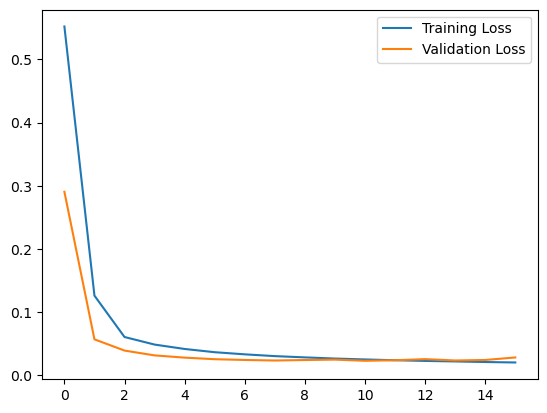

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


## Detecting anomalies
We will detect anomalies by determining how well our model can reconstruct
the input data.
1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.

118/118 [==============================] - 1s 4ms/step


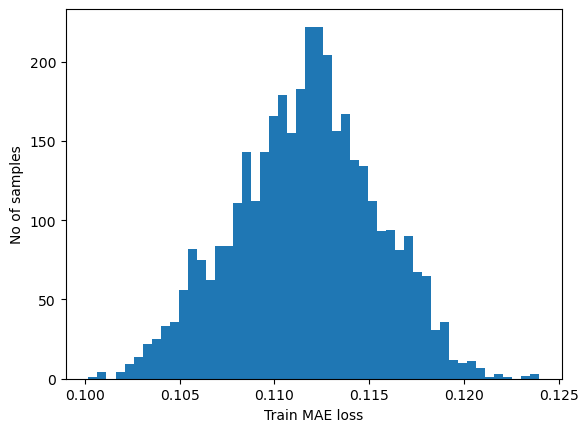

Reconstruction error threshold:  0.12396747961397936


In [11]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
# find the prediction and get value
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)


# then create a plot
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


### Compare recontruction
Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

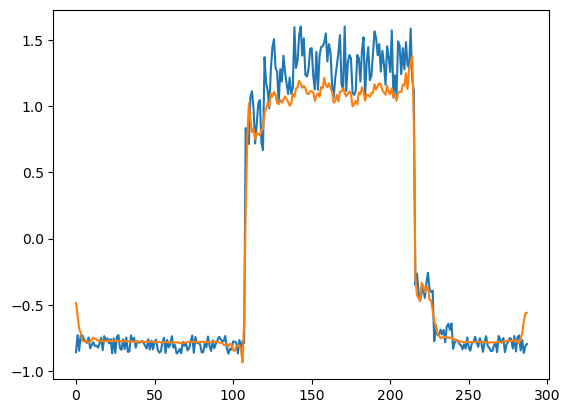

In [12]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()


### Prepare test data



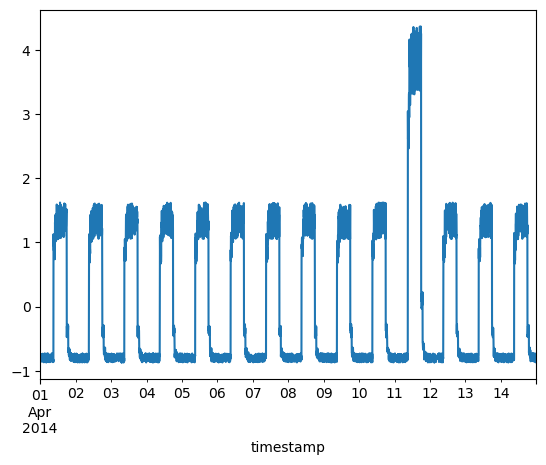

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 1s 5ms/step


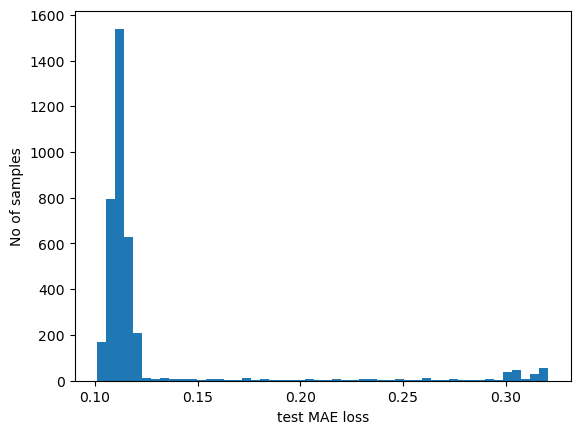

Number of anomaly samples:  399
Indices of anomaly samples:  (array([ 789, 1659, 2522, 2523, 2695, 2701, 2702, 2703, 2704, 2705, 2706,
       2707, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718,
       2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729,
       2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751,
       2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762,
       2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773,
       2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784,
       2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795,
       2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806,
       2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817,
       2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828,
       2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2

In [13]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


## Plot anomalies
We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:
Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:
- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9
All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [14]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


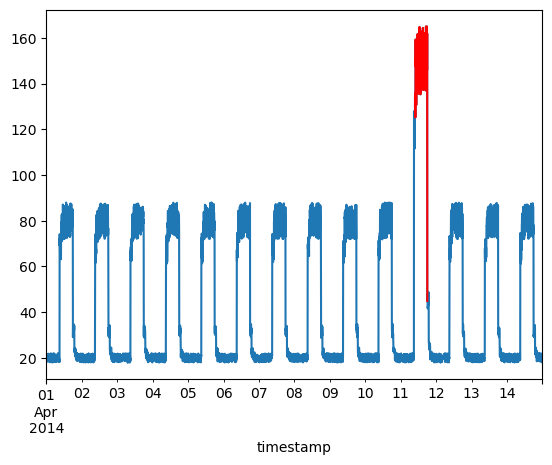

In [15]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()


<hr style="border-top: 1px solid rgb(0, 91, 94);" />

<h3>References</h3>
 
[1]  https://keras.io/examples/timeseries/timeseries_anomaly_detection/

[2] 

[3] 

[4] 

[5] 

[6] 

[7] 

[8] 

[9] 

[10]

[11]

[12]

[13] 

<hr style="border-top: 1px solid rgb(0, 91, 94);" />

<h3>END</h3>

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

https://www.kaggle.com/code/adithya44/anomaly-detection-with-time-series-forecasting

https://www.google.com/search?client=firefox-b-d&q=time+series+anomaly+detection+kaggle

https://www.google.com/search?client=firefox-b-d&q=Time+Series+anomaly+detection+using+Keras+explain&spell=1&sa=X&ved=2ahUKEwj3xLa67qT7AhX-RkEAHTSJDOoQBSgAegQIJBAB&biw=2560&bih=1287&dpr=1.5

https://neptune.ai/blog/anomaly-detection-in-time-series

https://www.google.com/search?client=firefox-b-d&q=examples+of+Time+Series+anomaly+detection+keras&spell=1&sa=X&ved=2ahUKEwjCgv3U7qT7AhWHWMAKHVNXA6MQBSgAegQIOhAB&biw=2560&bih=1287&dpr=1.5

https://valueml.com/anomaly-detection-in-time-series-data-using-keras/

https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9

https://huggingface.co/keras-io/timeseries-anomaly-detection?data=%7B%7D

https://www.youtube.com/watch?v=H4J74KstHTE

https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/
